# Quick Start: TimeSeries Loader

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nehalecky/hello-cloud/blob/master/notebooks/published/06_quickstart_timeseries_loader.ipynb)

## Overview

This notebook demonstrates the `TimeSeries` loader for hierarchical time series data. Learn how to:

- Load PiedPiper billing data in 3 lines
- Filter, sample, and aggregate entities
- Visualize time series with publication-quality plots
- Compute summary statistics across entities

**Target audience**: Data scientists working with hierarchical time series (billing, metrics, IoT)

**Prerequisites**: PiedPiper dataset (or substitute your own hierarchical time series data)

---

## Setup

In [1]:
# Environment Setup
# Local: Uses installed hellocloud
# Colab: Installs from GitHub
try:
    import hellocloud
except ImportError:
    !pip install -q git+https://github.com/nehalecky/hello-cloud.git
    import hellocloud

In [19]:
# Auto-reload: Picks up library changes without kernel restart
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_formats = ['png', 'retina']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# Standard imports
from pathlib import Path
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from loguru import logger

# PySpark and hellocloud
from pyspark.sql import functions as F
import hellocloud as hc

# Set seaborn theme for publication-quality plots

sns.set_theme()

# Get Spark session
spark = hc.spark.get_spark_session(app_name="quickstart-timeseries")

## 1. Loading Data

The `PiedPiperLoader` applies EDA-informed defaults to clean and structure billing data:

- **Column renames**: `usage_date` → `date`, `materialized_cost` → `cost`
- **Drops low-info columns**: UUIDs, redundant cost variants (4 removed)
- **Default hierarchy**: `provider → account → region → product → usage_type`

In [5]:
from hellocloud.io import PiedPiperLoader
from hellocloud.timeseries import TimeSeries

# Load raw data
#data_path = Path("../data/piedpiper_processed/piedpiper_clean")  # Adjust to your data location
#/cloudzero/hello-cloud/data/piedpiper_optimized_daily.parquet
data_path = Path("../../data/piedpiper_optimized_daily.parquet")
raw_df = spark.read.parquet(str(data_path))

print(f"Raw data: {raw_df.count():,} records, {len(raw_df.columns)} columns")

Raw data: 8,336,995 records, 38 columns


In [29]:
# Load into TimeSeries with defaults
# Loader logs all transformations (filtering, renaming, dropping columns)
ts = PiedPiperLoader.load(raw_df)

2025-10-15 14:01:44.836 | INFO     | hellocloud.io.loaders:load:80 - Loading PiedPiper data: 38 columns, 8,336,995 records
2025-10-15 14:01:44.837 | INFO     | hellocloud.io.loaders:load:85 - Using default column mapping
2025-10-15 14:01:44.841 | INFO     | hellocloud.io.loaders:load:98 - Filtered to 7 columns (removed 31)
2025-10-15 14:01:44.848 | INFO     | hellocloud.io.loaders:load:108 - Renamed 7 columns: usage_date → date, materialized_cost → cost, cloud_provider → provider, cloud_account_id → account, region → region, product_family → product, usage_type → usage
2025-10-15 14:01:44.914 | INFO     | hellocloud.io.loaders:load:128 - TimeSeries created: hierarchy=['provider', 'account', 'region', 'product', 'usage'], metric=cost, time=date, records=8,336,995


## Temporal Observation Density Analysis

  One of the first diagnostic checks for any time series dataset is **observation density** -
  how consistently are records captured over time?

  ### Why This Matters

  Real-world data collection is messy. Systems fail, APIs timeout, data pipelines have gaps.
  Before modeling or analysis, you need to understand:

  1. **Data Completeness**: Are there missing dates or sparse periods?
  2. **Collection Consistency**: Does observation frequency change over time?
  3. **Quality Issues**: Do sudden drops signal upstream problems?

  ### What the Plot Shows

  The temporal density plot displays:
  - **Top panel**: Record count per day (with shaded area for visual weight)
  - **Bottom panel** (optional): Day-over-day percent change
    - 🟢 Green bars = increases in observations
    - 🔴 Red bars = decreases in observations

  ### Interpretation Guide

  **Healthy patterns:**
  - Steady observation counts (flat line)
  - Small day-to-day variations (<10%)
  - No sudden drops or gaps

  **Warning signs:**
  - Sharp drops (>30-50%) suggest data quality issues
  - Increasing trends may indicate growing system coverage
  - Periodic spikes/drops might be business cycle effects (weekends, holidays)

25/10/15 14:09:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/15 14:09:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/15 14:09:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/15 14:09:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/15 14:09:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


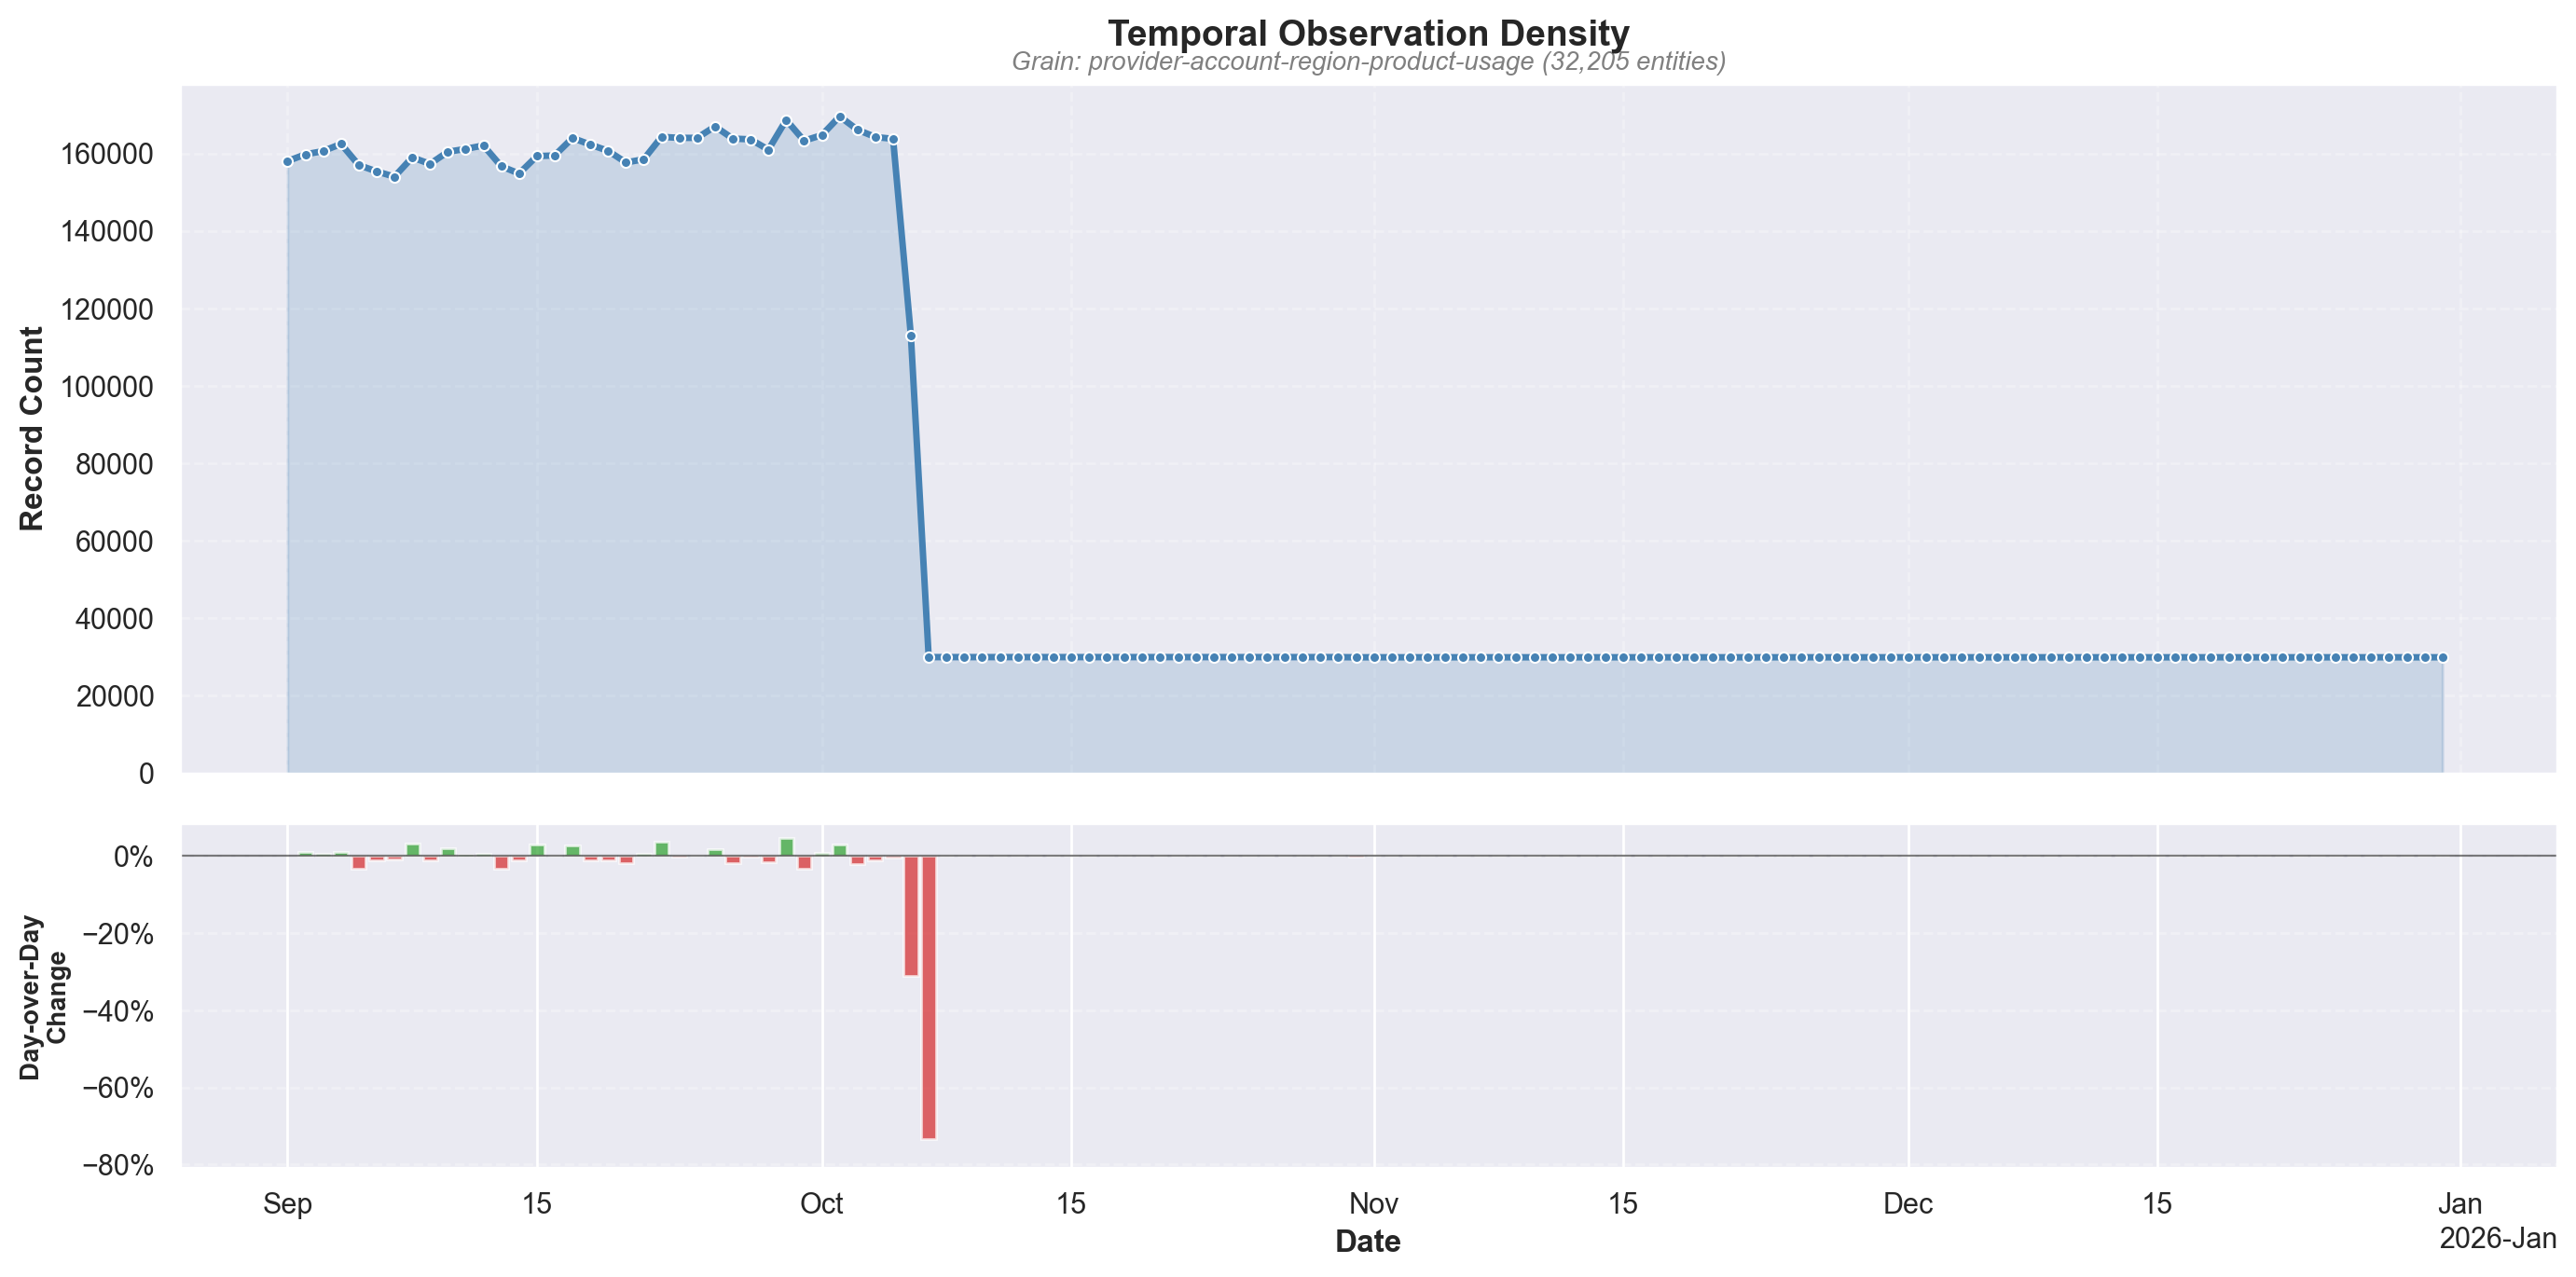

In [ ]:
# Overall record density over time.
ts.plot_temporal_density(show_pct_change=True)

**Observation**: We observe a sharp drop (> 30%) on 2025-10-06, and with data in future. We'll filter the time series to only consider data prior to this date.

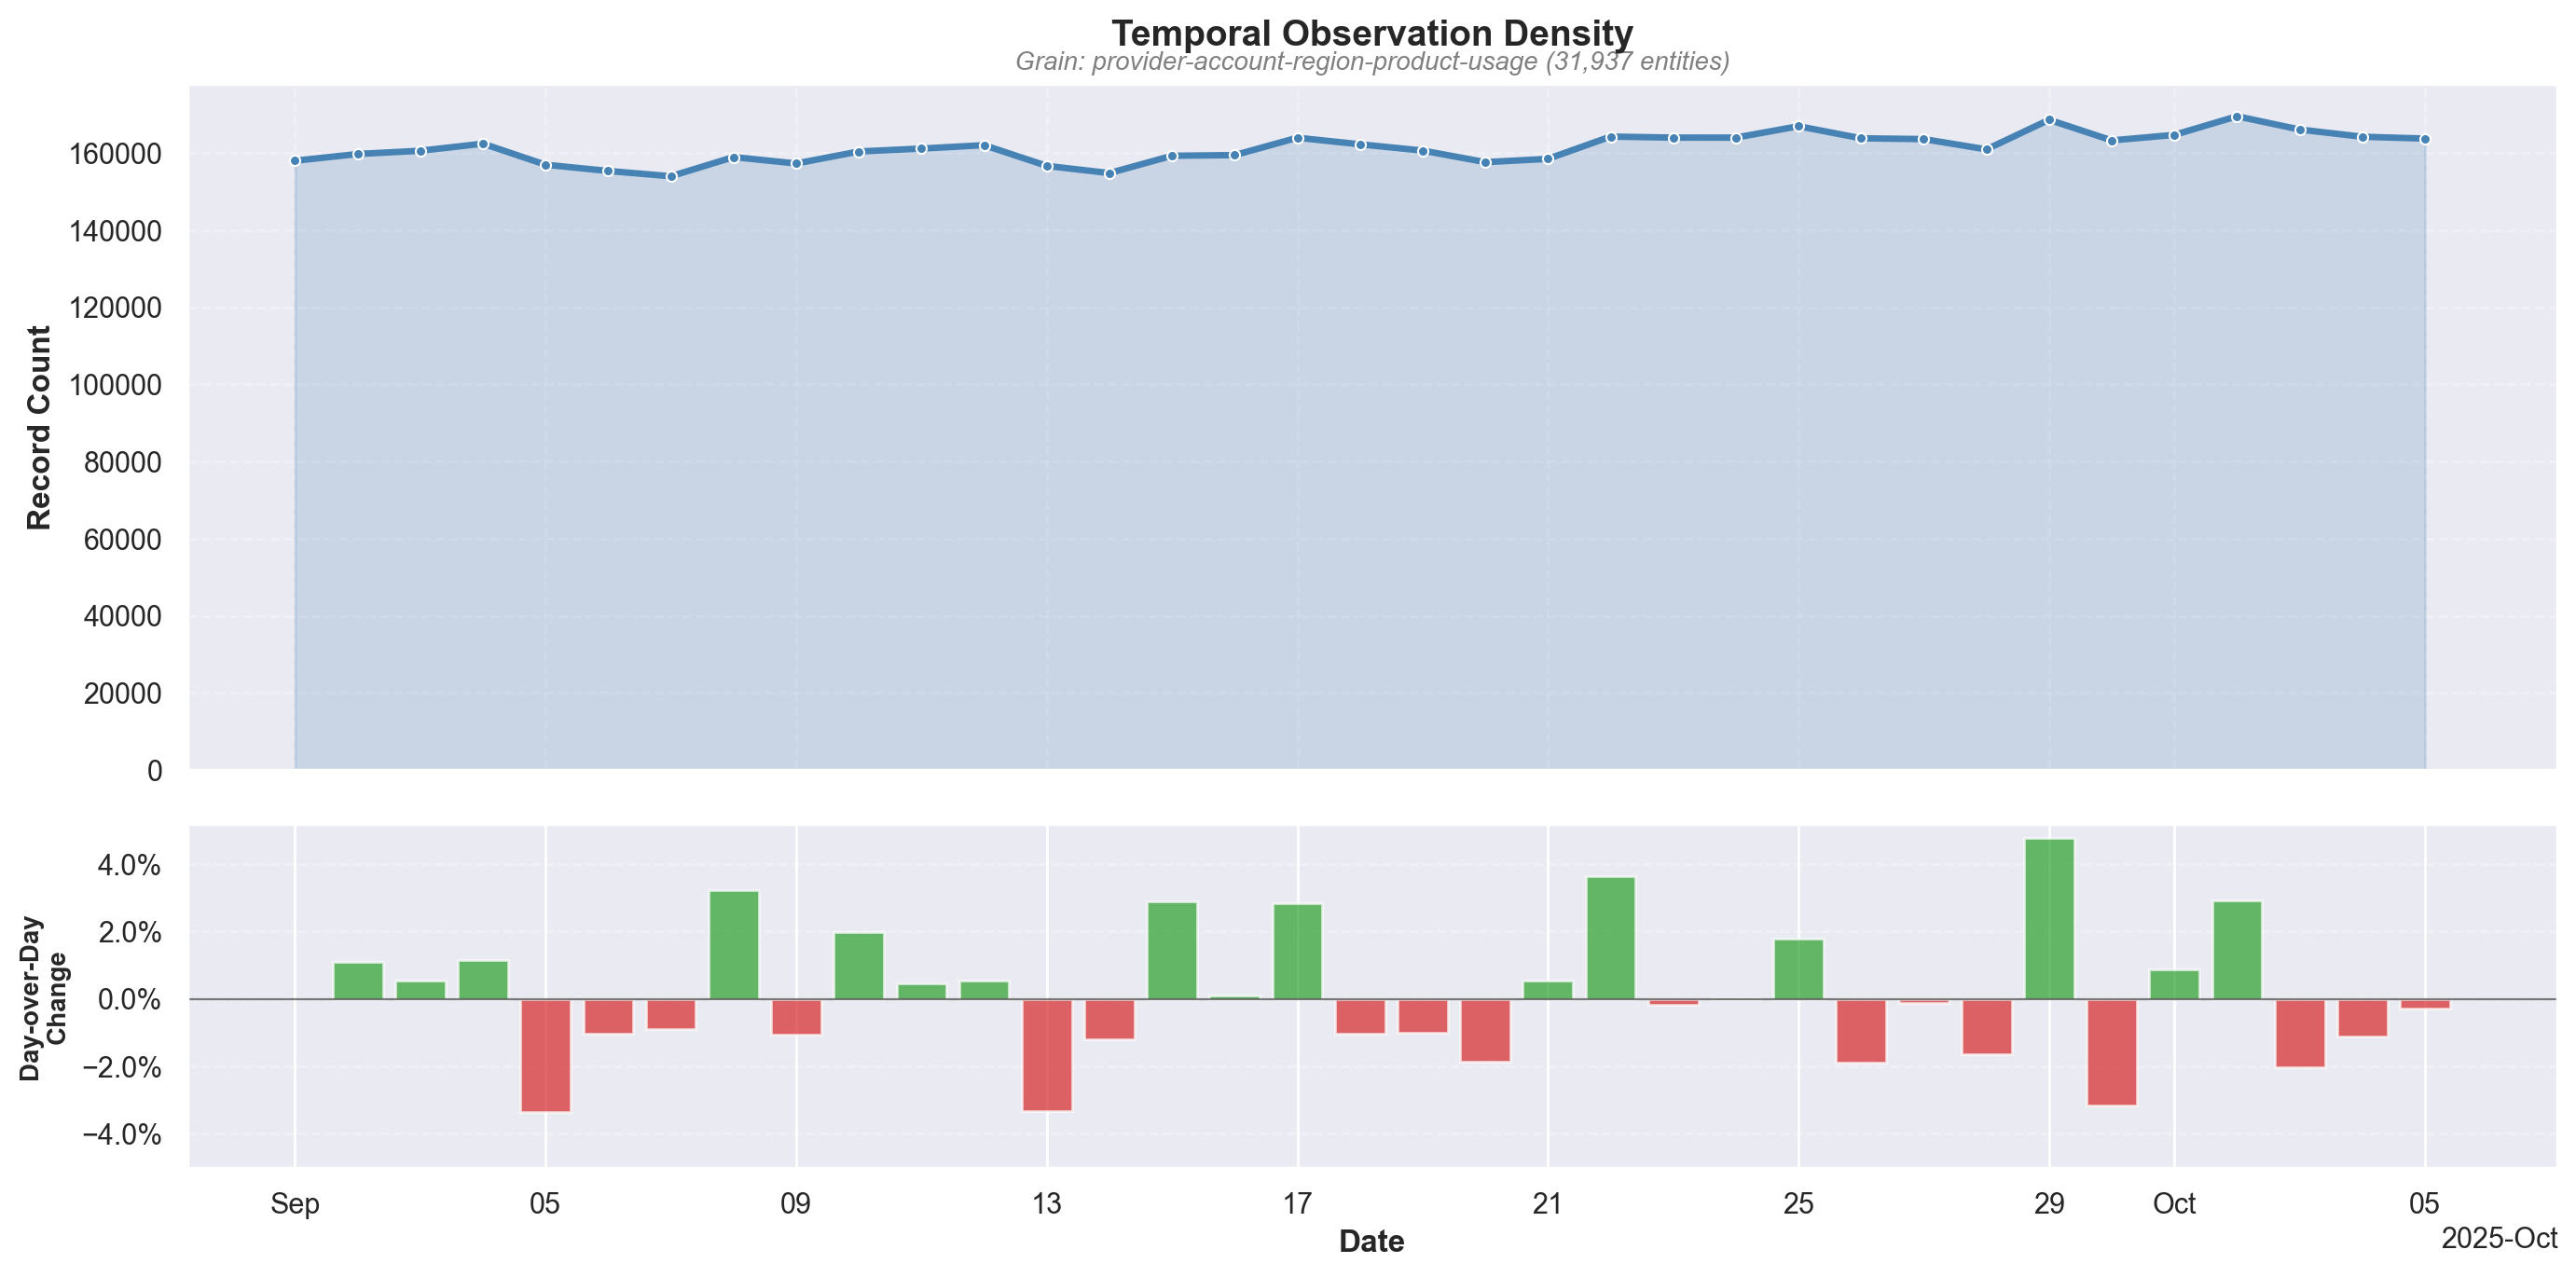

In [40]:
ts = ts.filter_time(end='2025-10-06')
ts.plot_temporal_density(show_pct_change=True)

Now we check record density across the additional distinct keys.

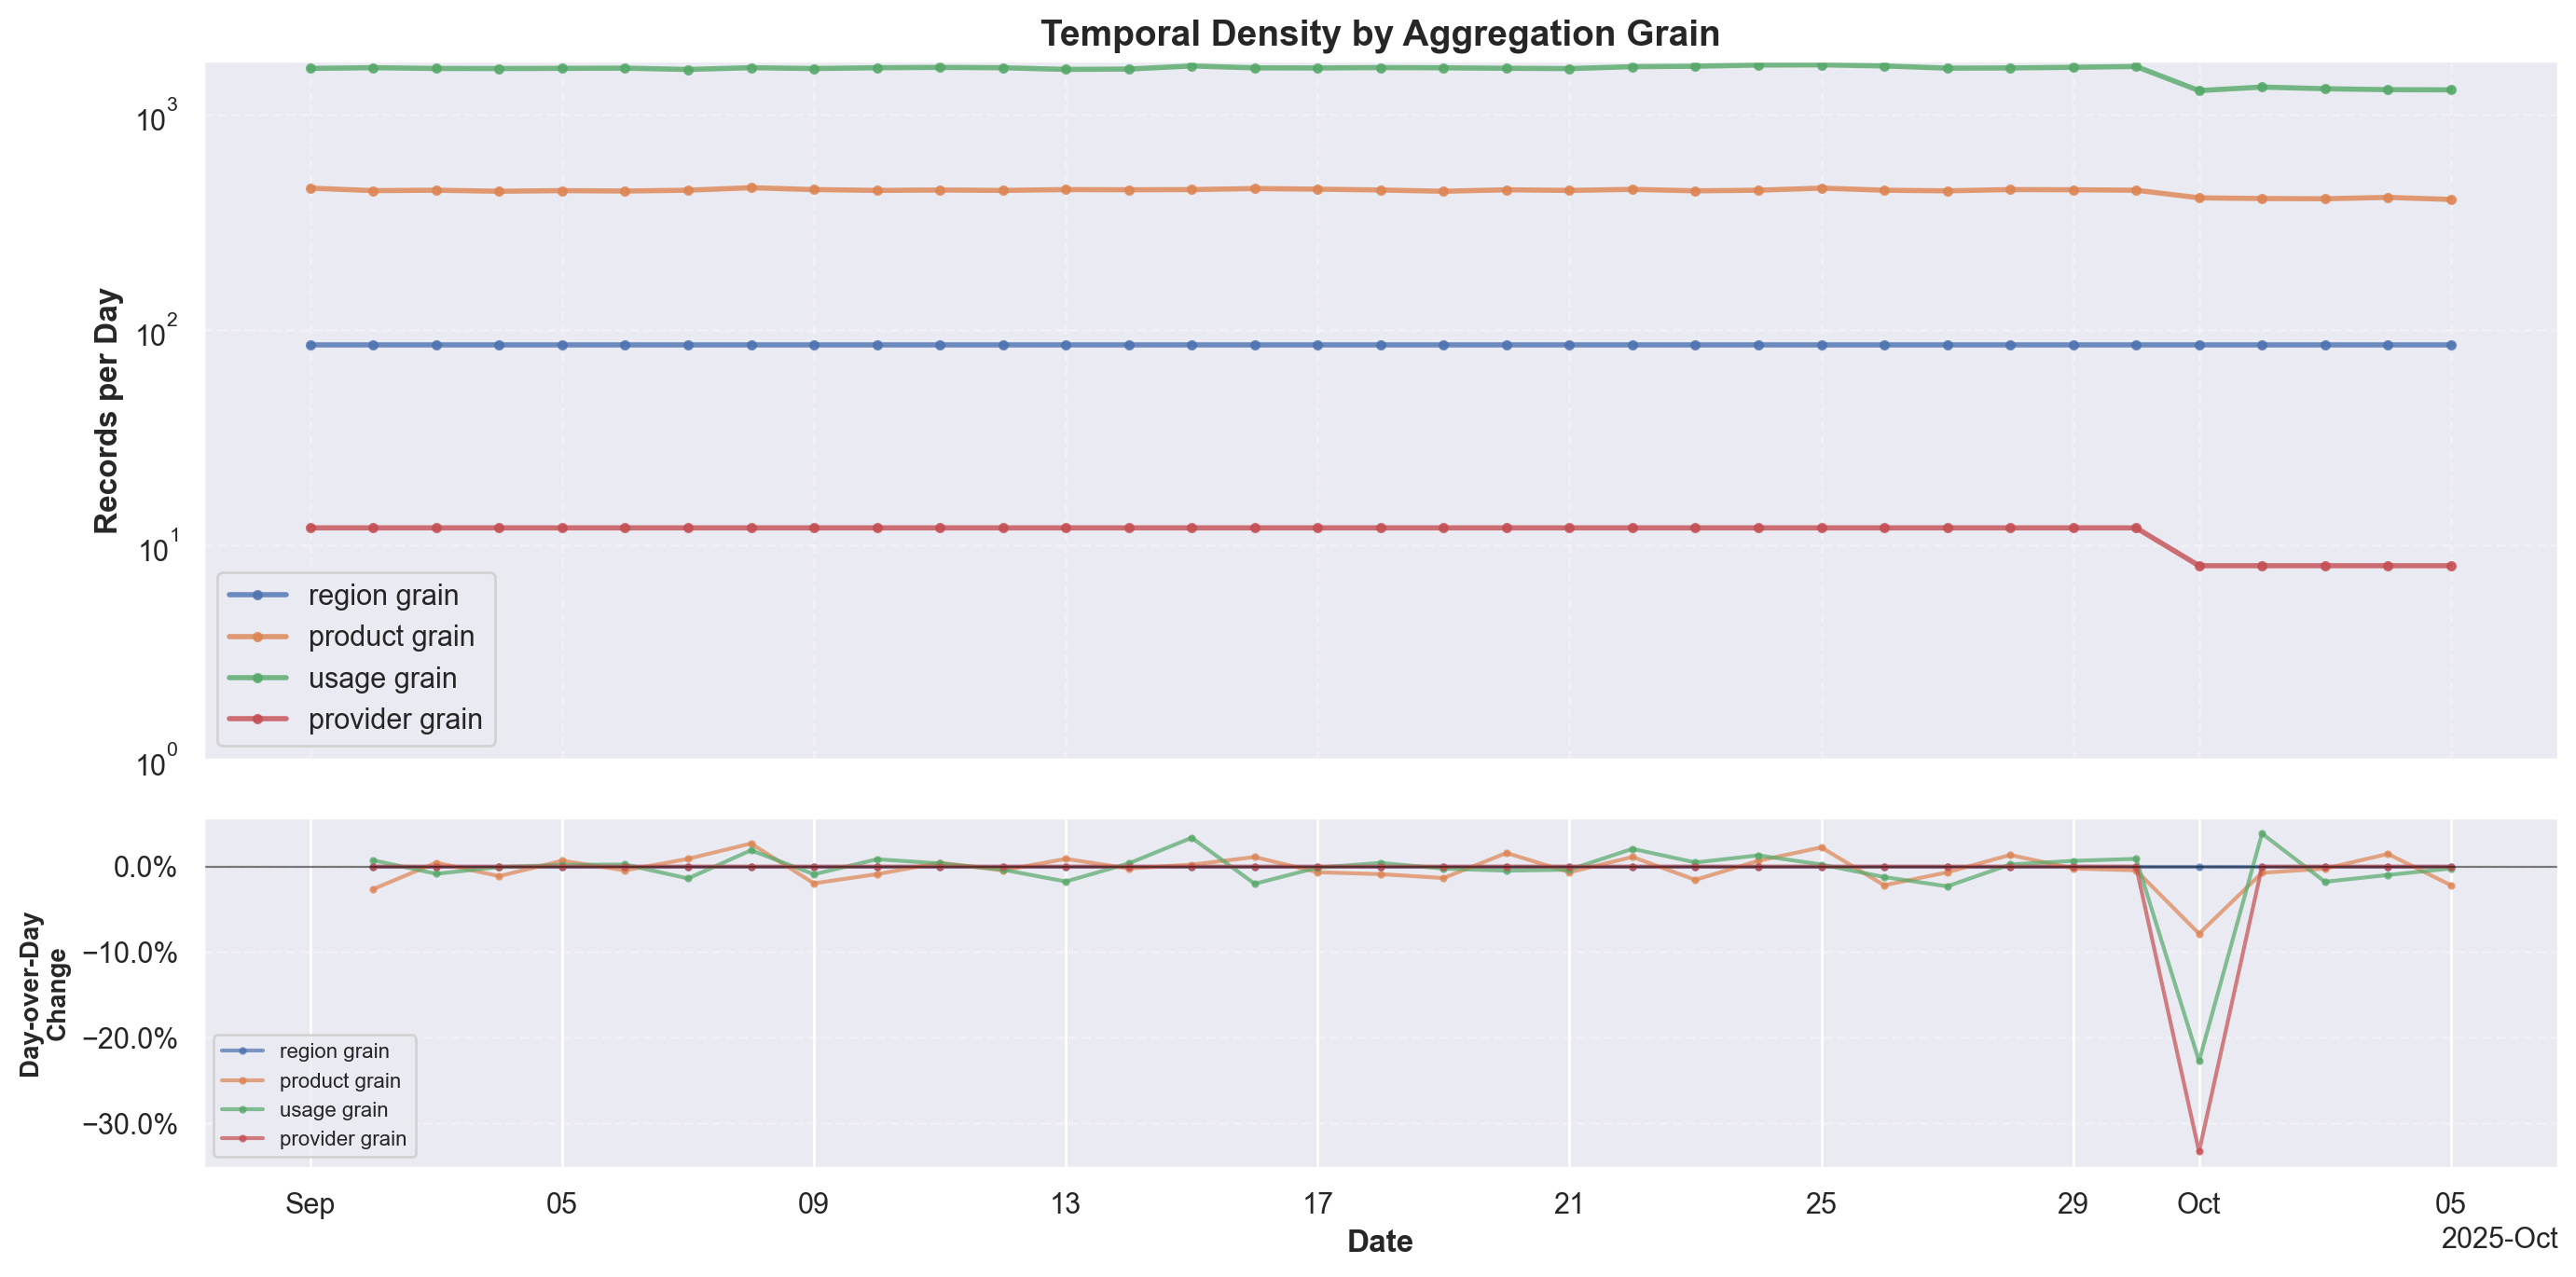

In [55]:
ts.plot_density_by_grain(['region', 'product', 'usage', 'provider'], show_pct_change=True)

We note some loss of distinct entities in the temporal density plot in the product, usage and provieder grains, however, overall data appears to be complete.

## Cost Analysis

In [61]:
ts.plot_cost_treemap(['provider', 'region'], top_n=30)

In [63]:
# 1. Summary statistics (DataFrame)
stats = ts.cost_summary_by_grain(['region'])
stats.toPandas().sort_values('total_cost', ascending=False)

,region,total_cost,mean_cost,median_cost,std_cost,min_cost,max_cost,days
0,us-east-1,1.192451e+07,340700.370708,392092.510642,109080.787635,71378.733787,412587.256079,35
1,no-region,1.139538e+06,32558.230495,32582.593281,1366.204615,29506.550782,36113.319284,35
2,us-central1,1.041910e+06,29768.847930,29826.449084,517.174284,28786.224850,30681.736249,35
3,westeurope,1.029959e+06,29427.402152,29544.617557,598.760155,28288.110086,30508.616580,35
4,eastus,1.009070e+06,28830.563290,28894.808675,528.233034,27845.405777,30173.288450,35
...,...,...,...,...,...,...,...,...
80,us-central2,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,35
81,eu-central-2,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,35
82,ap-east-2,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,35
83,eu-south-2,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,35


<string>:65: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<string>:70: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



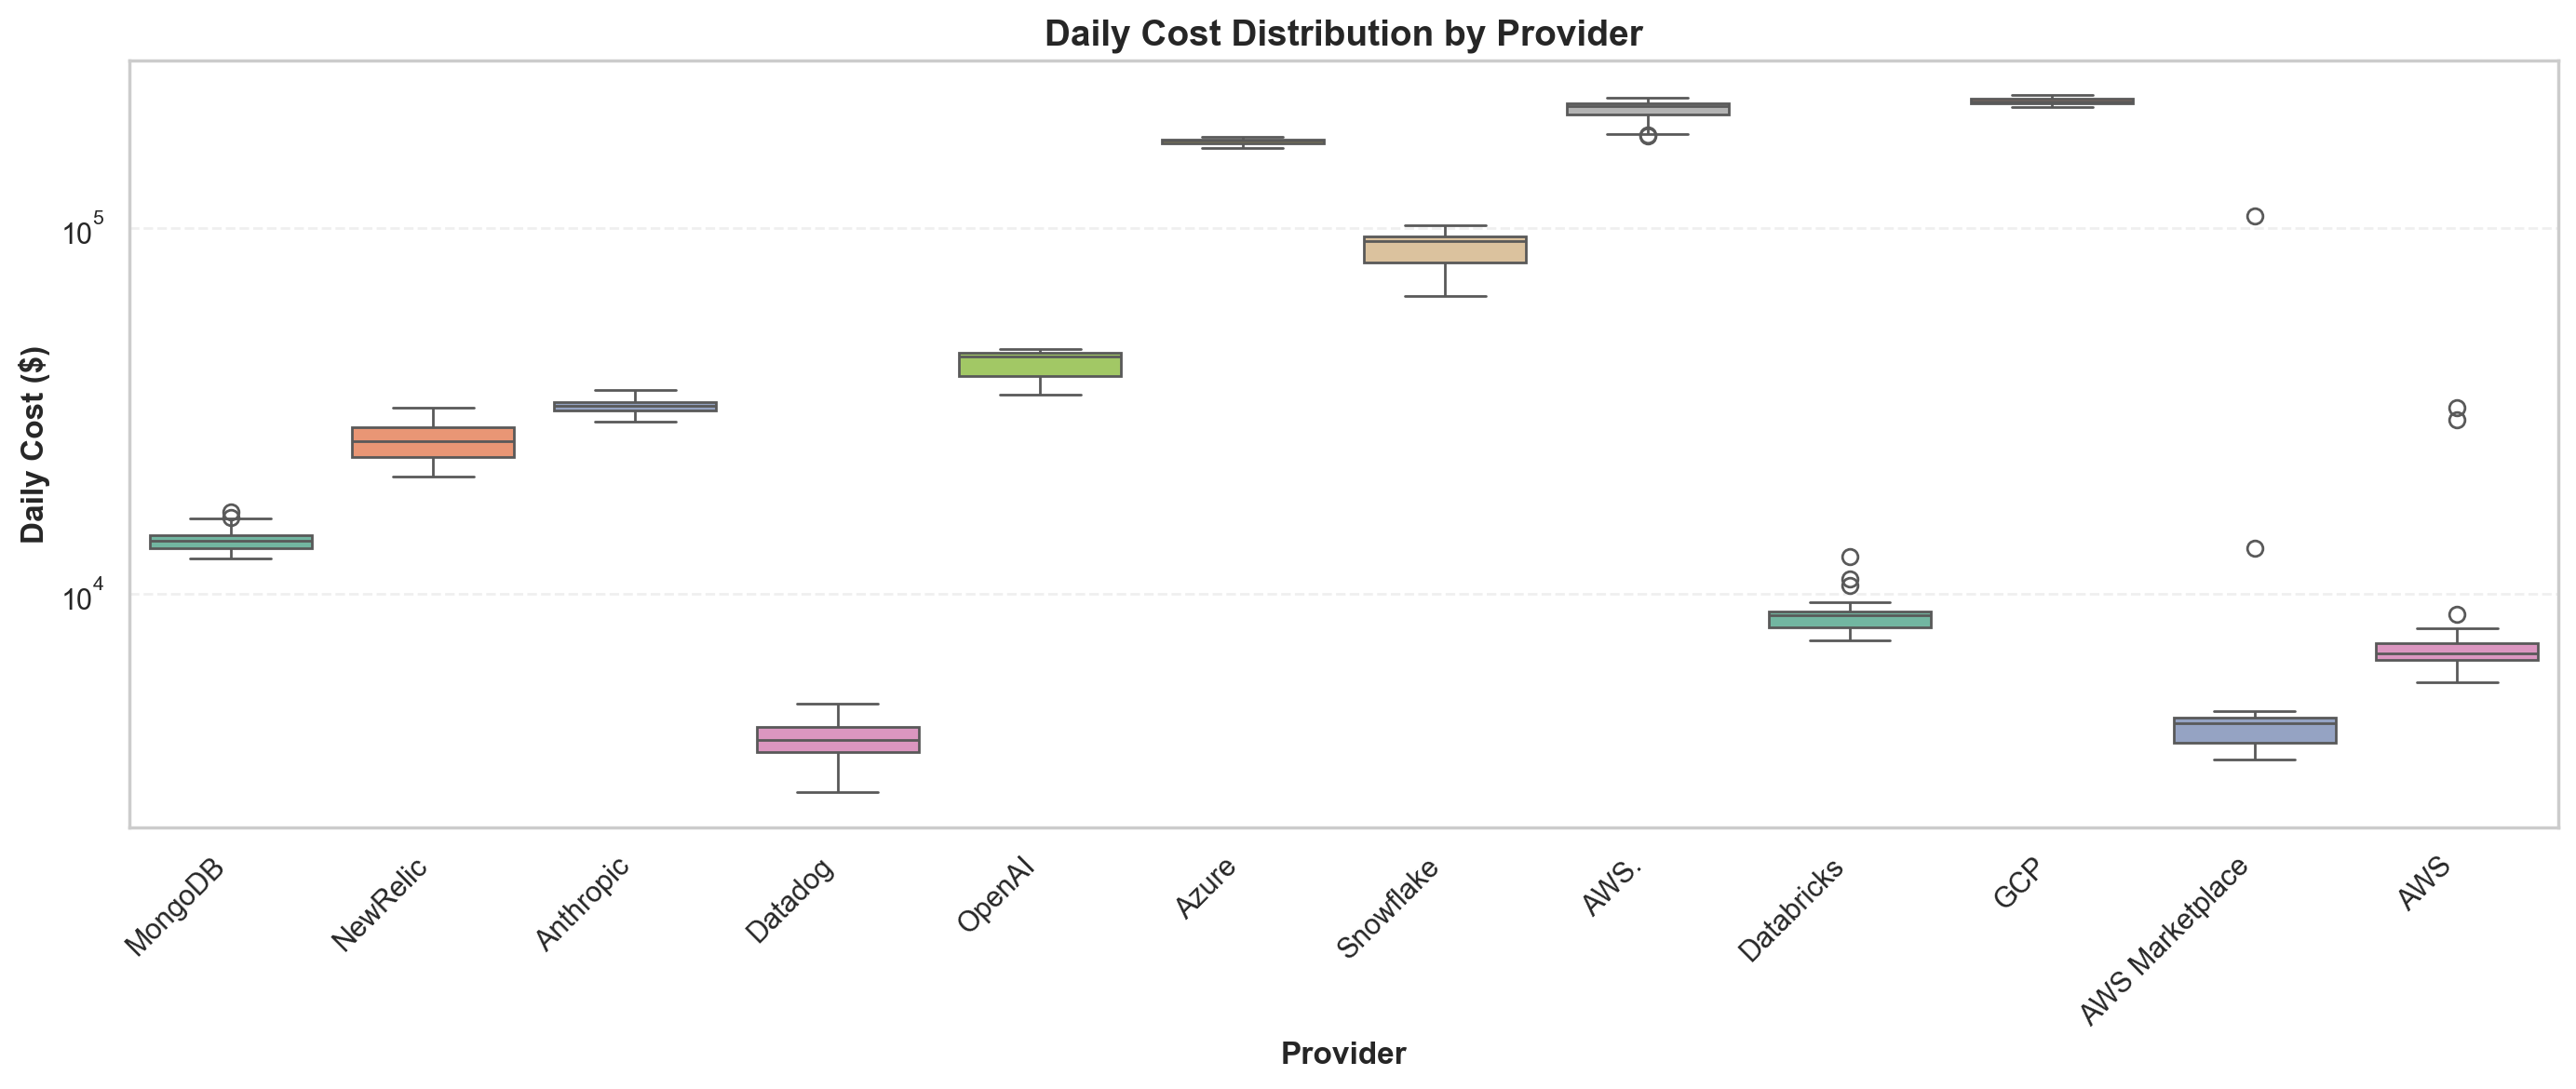

In [74]:
# 2. Box plot - Daily cost distributions
ts.plot_cost_distribution(['provider'], top_n=15, min_cost=10, log_scale=True)

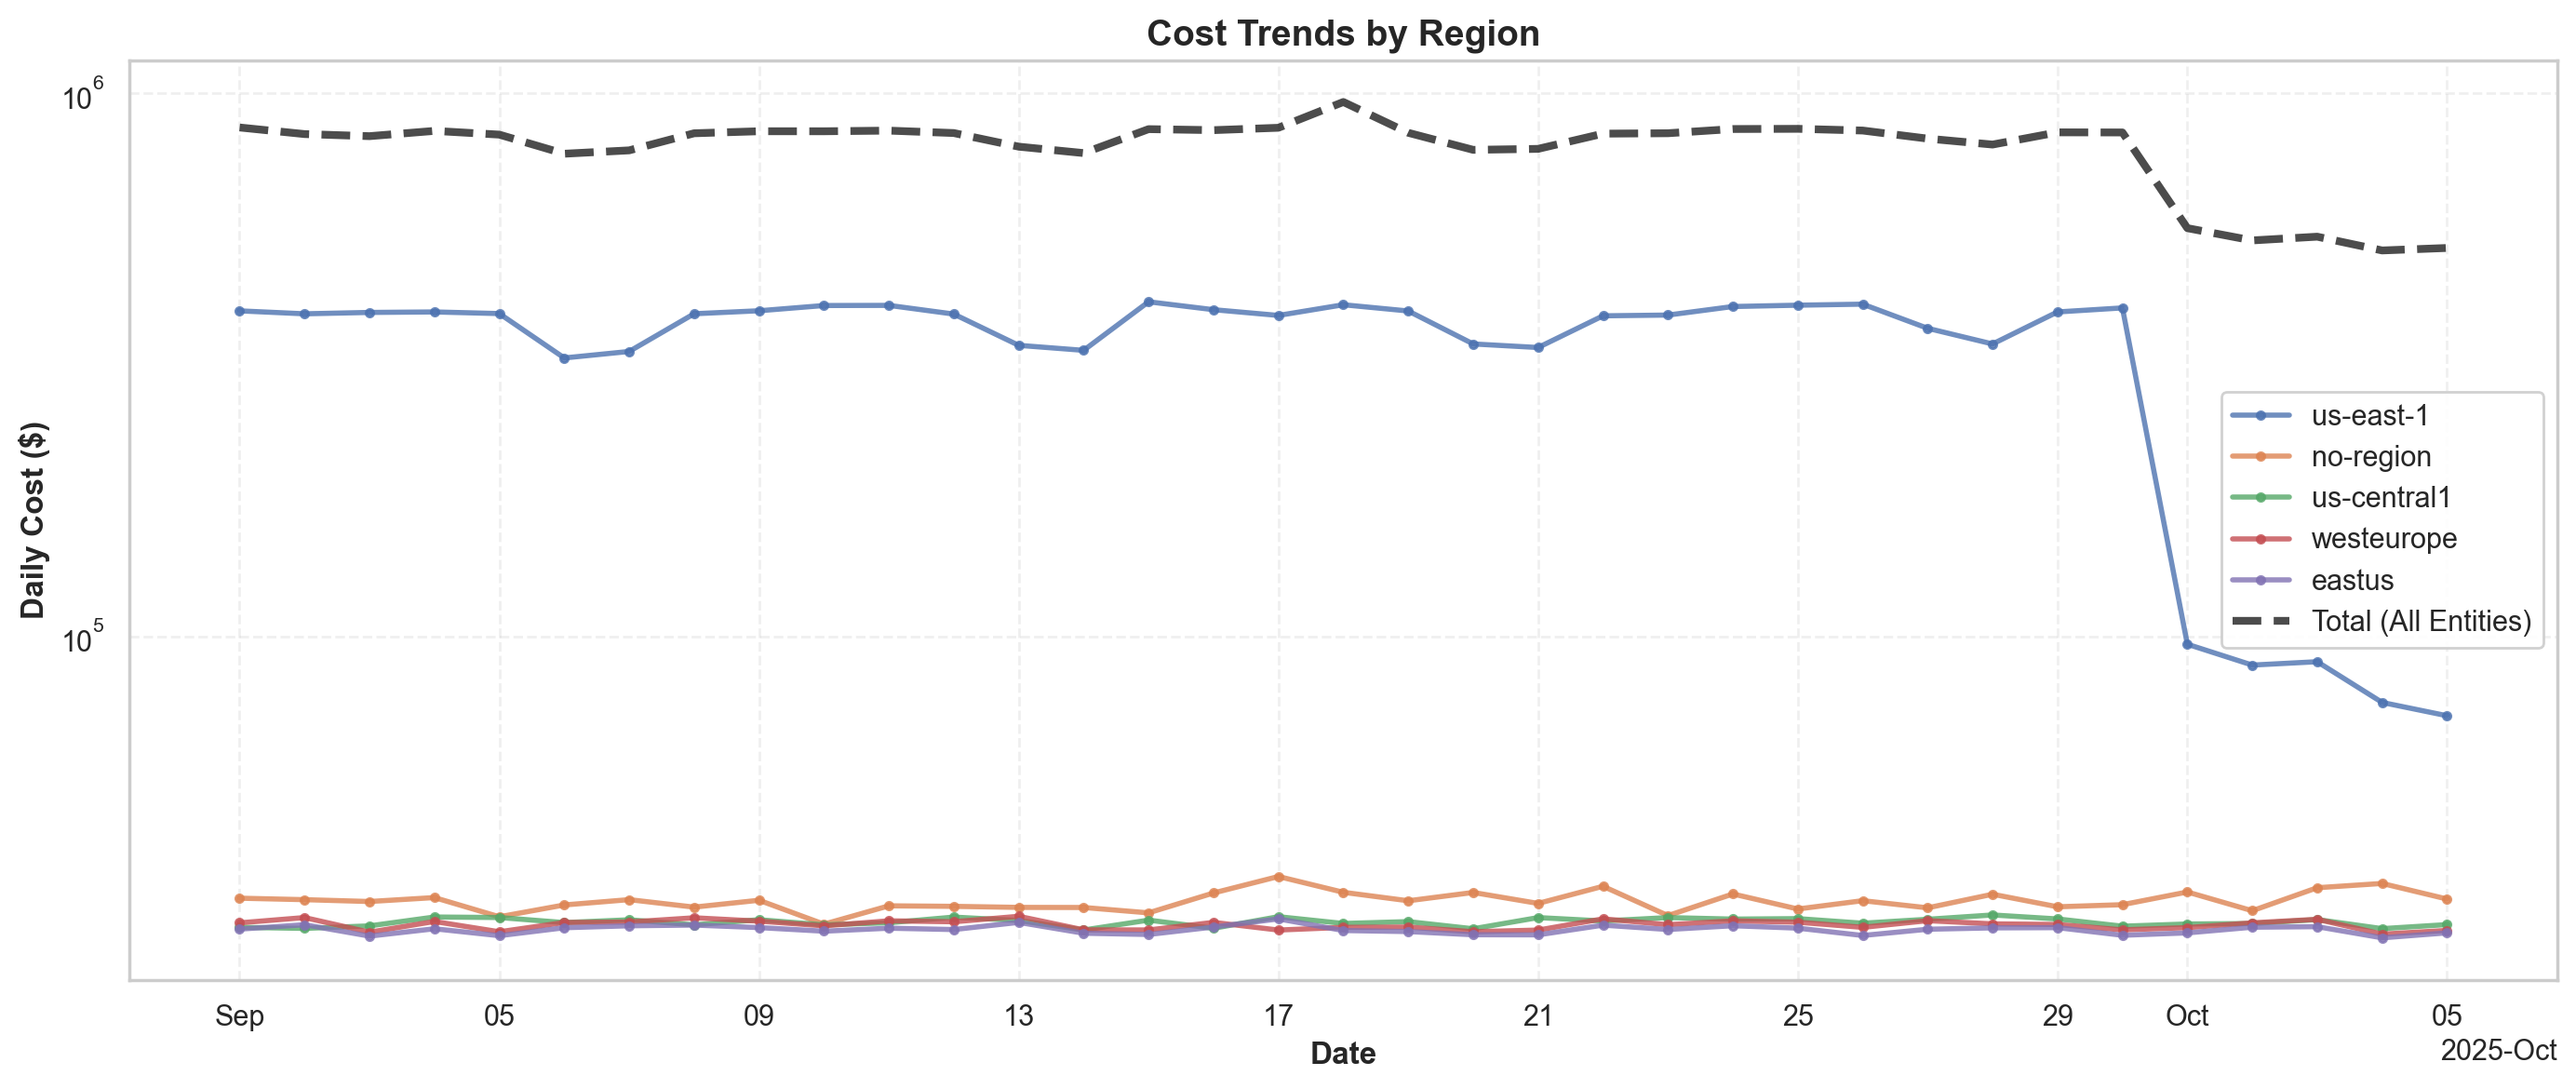

In [70]:
 # 3. Time series trends - Top spenders over time
ts.plot_cost_trends(['region'], top_n=5, show_total=True, log_scale=True)

**Key pattern**: Create the `ax` object, customize as needed, return `ax` for further manipulation.

---

## 5. Next Steps

### Deeper Analysis
- **Notebook 05**: Full EDA with grain discovery, entity persistence analysis
- **Hierarchical forecasting**: Use aggregate/filter to build multi-level models
- **Anomaly detection**: Compute z-scores with `summary_stats()`, flag outliers

### TimeSeries API
- **More operations**: See `hellocloud.timeseries.TimeSeries` for complete API
- **Transformations**: Use `hellocloud.transforms` for percent change, normalization
- **Custom grains**: Mix and match hierarchy levels for your analysis needs

### Data Sources
- **Extend PiedPiperLoader**: Add custom column mappings, filters
- **New loaders**: Create loaders for other datasets following the same pattern
- **Real-time data**: Integrate with streaming PySpark DataFrames

---

## Summary

**What we learned:**
- ✅ Load hierarchical time series data with `PiedPiperLoader`
- ✅ Filter, sample, and aggregate using `TimeSeries` methods
- ✅ Compute summary statistics across entities
- ✅ Create publication-quality plots with automatic date formatting
- ✅ Customize plots with matplotlib pass-through

**Key insight**: The `TimeSeries` class keeps the full dataset in memory once. Operations like `filter()`, `sample()`, and `aggregate()` return new instances with filtered/aggregated DataFrames—leveraging PySpark's distributed engine while providing a domain-specific API.

**Architecture**: `TimeSeries` → PySpark DataFrame → Distributed processing